In [44]:
#!pip install seaborn

In [45]:
#!pip install dataprep

In [46]:
#!pip install missingno

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import missingno as msno
#from dataprep.eda import plot, plot_correlation, create_report, plot_missing

from typing import List, Union

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import lightgbm as lgb

## Загрузка данных

In [48]:
path = 'data'

In [49]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
train.head()

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [51]:
test.head()

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1
3,Иркутск,1.0,COL_289354,5,76,139,231,0,0,0,...,1947.073276,1941.657895,Иркутская область,52.281380,104.282975,66.503622,S14207,2020-09-06,100,1
4,Курск,NaN,COL_289399,8,105,189,279,0,0,2,...,1948.764151,1946.689655,Курская область,51.729706,36.194019,23.864915,S20658,2020-09-06,10,1


In [52]:
train.shape

(279792, 77)

In [53]:
test.shape

(2974, 76)

## Data processing

In [54]:
df = pd.concat([train, test], axis=0, ignore_index=True)
df

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.000000,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.000000,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.400000,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.000000,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.200000,S1338,2020-01-05,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282761,Красноярск,4.0,COL_455089,55.978180,92.891457,0,3,6,16,0,...,5.730769,6.333333,1972.153846,1982.250000,Красноярский край,2149.546362,S2650,2020-12-27,100,1
282762,Томск,1.0,COL_455212,56.459183,84.979872,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,Томская область,359.371061,S11114,2020-12-27,10,1
282763,Калуга,-1.0,COL_455261,54.523247,36.295168,2,25,54,99,0,...,3.983871,4.909091,1966.390244,1966.904762,Калужская область,87.820453,S34005,2020-12-27,100,1
282764,Нижний Новгород,NaN,COL_455381,56.328236,43.990039,13,70,114,158,0,...,3.829268,4.529412,1938.331361,1946.529412,Нижегородская область,208.625735,S21753,2020-12-27,10,1


In [55]:
# замена
def floor_processing(df):
    floor_dict = {
        np.nan: 1,
        'цоколь': 1,
        '1 этаж': 1,
        'цоколь, 1': 1,
        '1': 1,
        '1.0': 1,

        'подвал': -1,
        '-1.0': -1,
        '-1': -1,

        '1, подвал': -0.5,
        'подвал , 1': -0.5,
        'подвал, 1': -0.5,

        '-2.0': -2,
        '-3.0': -3,

        '1,2': 1.5,
        '1, 2': 1.5,
        '4 этаж': 4,
    }

    df['floor'] = df['floor'].replace(floor_dict)

    # меняем нечиловые описания на нули https://stackoverflow.com/a/43744114
    df['floor'] = (
        pd.to_numeric(df['floor'],
                      errors='coerce')
          .fillna(0)
        )
    return df

In [56]:
df = floor_processing(df)

In [57]:
df

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,1.0,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.000000,S27289,2020-01-05,10,0
1,Шатура,1.0,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.000000,S17052,2020-01-05,10,0
2,Ярославль,1.0,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.400000,S16913,2020-01-05,110,0
3,Новокузнецк,1.0,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.000000,S10148,2020-01-05,110,0
4,Москва,1.0,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.200000,S1338,2020-01-05,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282761,Красноярск,4.0,COL_455089,55.978180,92.891457,0,3,6,16,0,...,5.730769,6.333333,1972.153846,1982.250000,Красноярский край,2149.546362,S2650,2020-12-27,100,1
282762,Томск,1.0,COL_455212,56.459183,84.979872,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,Томская область,359.371061,S11114,2020-12-27,10,1
282763,Калуга,-1.0,COL_455261,54.523247,36.295168,2,25,54,99,0,...,3.983871,4.909091,1966.390244,1966.904762,Калужская область,87.820453,S34005,2020-12-27,100,1
282764,Нижний Новгород,1.0,COL_455381,56.328236,43.990039,13,70,114,158,0,...,3.829268,4.529412,1938.331361,1946.529412,Нижегородская область,208.625735,S21753,2020-12-27,10,1


# Модель

In [58]:
cat_feat = ['region', 'city', 'street', 'realty_type', 'osm_city_nearest_name', 'date']
cat_feat

['region', 'city', 'street', 'realty_type', 'osm_city_nearest_name', 'date']

In [59]:
def label_encoder(df, cat_feat):
    """
    Кодируем категориальные
    """
    le = preprocessing.LabelEncoder()
    for col in cat_feat:
        # уникальные значения по колонке
        values = df[col].unique()
        # Fit label encoder
        le.fit(values)
        # преобразуем 
        df[col] = le.transform(df[col])
        
    return df

In [60]:
label_encoder(df, cat_feat)

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,3063,1.0,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,31,32.000000,16168,0,0,0
1,4442,1.0,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,25,280.000000,6512,0,0,0
2,4615,1.0,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,48,297.400000,6367,0,2,0
3,2683,1.0,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,14,190.000000,115,0,2,0
4,2465,1.0,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,24,60.200000,3121,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282761,1946,4.0,COL_455089,55.978180,92.891457,0,3,6,16,0,...,5.730769,6.333333,1972.153846,1982.250000,19,2149.546362,15419,50,1,1
282762,3964,1.0,COL_455212,56.459183,84.979872,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,41,359.371061,1028,50,0,1
282763,1511,-1.0,COL_455261,54.523247,36.295168,2,25,54,99,0,...,3.983871,4.909091,1966.390244,1966.904762,12,87.820453,22665,50,1,1
282764,2624,1.0,COL_455381,56.328236,43.990039,13,70,114,158,0,...,3.829268,4.529412,1938.331361,1946.529412,26,208.625735,10937,50,0,1


In [61]:
df[cat_feat]

,region,city,street,realty_type,osm_city_nearest_name,date
0,31,3063,16168,0,109,0
1,25,4442,6512,0,104,0
2,48,4615,6367,2,167,0
3,14,2683,115,2,89,0
4,24,2465,3121,0,156,0
...,...,...,...,...,...,...
282761,19,1946,15419,1,64,50
282762,41,3964,1028,0,147,50
282763,12,1511,22665,1,49,50
282764,26,2624,10937,0,87,50


In [62]:
TARGET = 'per_square_meter_price'

## 1-й вариант разделения

In [63]:
# train = df.iloc[:279792].copy()
# print(train.shape)
# train.head()

In [64]:
# test = df.iloc[279792:].copy()
# test.drop([TARGET], axis=1, inplace=True)
# print(test.shape)
# test.head()

## 2-й вариант разделения

In [65]:
train = df.iloc[:279792].copy()
print(train.shape)
train.head()

(279792, 77)


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,3063,1.0,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,31,32.0,16168,0,0,0
1,4442,1.0,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,25,280.0,6512,0,0,0
2,4615,1.0,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,48,297.4,6367,0,2,0
3,2683,1.0,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,14,190.0,115,0,2,0
4,2465,1.0,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,24,60.2,3121,0,0,0


In [66]:
train = train[train['price_type'] == 1].copy()
train

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
275299,1946,1.0,COL_62,56.063615,92.958428,0,7,14,26,0,...,7.136842,7.612903,1976.684211,1980.483871,19,106.351104,25063,0,2,1
275300,3424,1.0,COL_71,51.534581,46.020549,13,198,345,462,0,...,4.144608,4.164557,1940.591549,1939.348837,36,175.039602,16845,0,0,1
275301,1946,1.0,COL_140,56.026884,92.818323,3,15,23,33,0,...,6.851429,5.742424,1976.714286,1972.878788,19,89.534921,12719,0,0,1
275302,1385,1.0,COL_202,52.275528,104.251444,0,10,26,40,0,...,4.597222,5.469388,1968.098131,1975.530612,10,419.557752,502,0,0,1
275303,254,1.0,COL_207,50.576545,36.584197,4,48,73,92,0,...,9.157480,9.088235,1983.125984,1980.470588,4,1098.703185,1126,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279787,3964,1.0,COL_280111,56.459183,84.979334,2,33,111,222,0,...,5.714286,5.882353,1972.260870,1973.460000,41,358.320073,1028,33,0,1
279788,3417,1.0,COL_280479,59.936954,30.356383,10,274,718,1340,0,...,4.719388,4.706667,1876.994898,1873.186667,35,119.637556,17313,33,2,1
279789,1497,3.0,COL_280518,54.729233,20.514968,0,12,34,84,0,...,3.950413,4.885714,1964.258333,1970.571429,11,312.789725,25857,33,0,1
279790,1586,1.0,COL_280529,55.360680,86.081460,5,57,100,134,0,...,4.691489,4.125000,1957.425532,1954.625000,14,89.201305,7094,33,2,1


In [67]:
X_train = train.drop([TARGET, 'id'], axis=1)
X_train

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
275299,1946,1.0,56.063615,92.958428,0,7,14,26,0,0,...,7.136842,7.612903,1976.684211,1980.483871,19,106.351104,25063,0,2,1
275300,3424,1.0,51.534581,46.020549,13,198,345,462,0,0,...,4.144608,4.164557,1940.591549,1939.348837,36,175.039602,16845,0,0,1
275301,1946,1.0,56.026884,92.818323,3,15,23,33,0,0,...,6.851429,5.742424,1976.714286,1972.878788,19,89.534921,12719,0,0,1
275302,1385,1.0,52.275528,104.251444,0,10,26,40,0,1,...,4.597222,5.469388,1968.098131,1975.530612,10,419.557752,502,0,0,1
275303,254,1.0,50.576545,36.584197,4,48,73,92,0,0,...,9.157480,9.088235,1983.125984,1980.470588,4,1098.703185,1126,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279787,3964,1.0,56.459183,84.979334,2,33,111,222,0,0,...,5.714286,5.882353,1972.260870,1973.460000,41,358.320073,1028,33,0,1
279788,3417,1.0,59.936954,30.356383,10,274,718,1340,0,2,...,4.719388,4.706667,1876.994898,1873.186667,35,119.637556,17313,33,2,1
279789,1497,3.0,54.729233,20.514968,0,12,34,84,0,2,...,3.950413,4.885714,1964.258333,1970.571429,11,312.789725,25857,33,0,1
279790,1586,1.0,55.360680,86.081460,5,57,100,134,0,0,...,4.691489,4.125000,1957.425532,1954.625000,14,89.201305,7094,33,2,1


In [68]:
y_train = train[TARGET]
y_train

275299    103120.697310
275300     24874.371004
275301     80058.148547
275302     24649.765045
275303     39135.228322
              ...      
279787     54278.287605
279788    595298.017731
279789     35758.847259
279790     38755.038322
279791     41335.014762
Name: per_square_meter_price, Length: 4493, dtype: float64

In [72]:
test = df.iloc[279792:].copy()
test.drop([TARGET], axis=1, inplace=True)
print(test.shape)
test.head()

(2974, 76)


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
279792,2059,1.0,COL_289284,51.709255,36.147908,7,55,85,117,0,...,4.325000,4.211268,1966.471591,1966.740260,20,156.148996,26162,34,1,1
279793,3801,1.0,COL_289305,61.233240,73.462509,8,70,112,140,0,...,5.389831,5.500000,1988.259259,1989.068182,46,190.737943,17948,34,2,1
279794,4095,-1.0,COL_289318,57.143110,65.554573,3,28,67,122,0,...,7.915493,8.250000,1985.880282,1991.458333,43,457.118051,12853,34,0,1
279795,1385,1.0,COL_289354,52.281380,104.282975,5,76,139,231,0,...,3.276860,3.012048,1947.073276,1941.657895,10,66.503622,3905,34,1,1
279796,2059,1.0,COL_289399,51.729706,36.194019,8,105,189,279,0,...,4.346154,4.827586,1948.764151,1946.689655,20,23.864915,9920,34,0,1


In [238]:
# X_train, X_test, y_train, y_test = train_test_split(train.drop([TARGET, 'id'], axis=1), train[TARGET], 
#                                                     test_size=0.25, random_state=42, shuffle=True)

In [239]:
# X_train.shape, y_train.shape

((209844, 75), (209844,))

In [240]:
# X_test.shape, y_test.shape

((69948, 75), (69948,))

In [18]:
# реализация метрики от организаторов
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true, y_pred):
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_pred: np.array, y_true: np.array) -> float:
    return 'deviation_metric', np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean(), False

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

def metrics_stat(y_true: np.array, y_pred: np.array):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mdape = median_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    raif_metric = deviation_metric(y_true, y_pred)
    return {'mape':mape, 'mdape':mdape, 'rmse': rmse, 'r2': r2, 'raif_metric':raif_metric}

In [69]:
%%time
lgb_params = { 
     'boosting_type': 'gbdt',
#     'n_estimators': 10000,
#     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
#     'num_leaves': 10, # default = 31
#     'min_data_in_leaf':10000, # default = 20
#     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'lambda_l1': 2,
#     'lambda_l2': 0,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 0.7,
#     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

params_lgbm = {
               'boosting_type': 'dart',
               'num_leaves': 887,
               'n_estimators': 480,
               'max_depth': 11,
               'min_child_samples': 1073,
               'learning_rate': 0.05348257149091985,
               'min_data_in_leaf': 2,
               'feature_fraction': 0.9529134909800754
              }


model = lgb.LGBMRegressor(**params_lgbm)
model.fit(
    X=X_train, 
    y=y_train,
    #eval_set=[(X_train, y_train), (X_test, y_test)],
    #eval_names=["train", "test"],
    early_stopping_rounds=10,
    eval_metric=deviation_metric,
    verbose=25
)

/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


CPU times: user 41.6 s, sys: 564 ms, total: 42.2 s
Wall time: 10.7 s


LGBMRegressor(boosting_type='dart', feature_fraction=0.9529134909800754,
              learning_rate=0.05348257149091985, max_depth=11,
              min_child_samples=1073, min_data_in_leaf=2, n_estimators=480,
              num_leaves=887)

In [73]:
train_predictions = model.predict(X_train)
#test_predictions = model.predict(X_test)
submission = model.predict(test.drop(['id'], axis=1))

In [74]:
metrics_stat(y_train.to_numpy(), train_predictions)

{'mape': 0.06325673043098842,
 'mdape': 0.05080296680670173,
 'rmse': 6140.171401666632,
 'r2': 0.9952835789098736,
 'raif_metric': ('deviation_metric', 0.012511099484069201, False)}

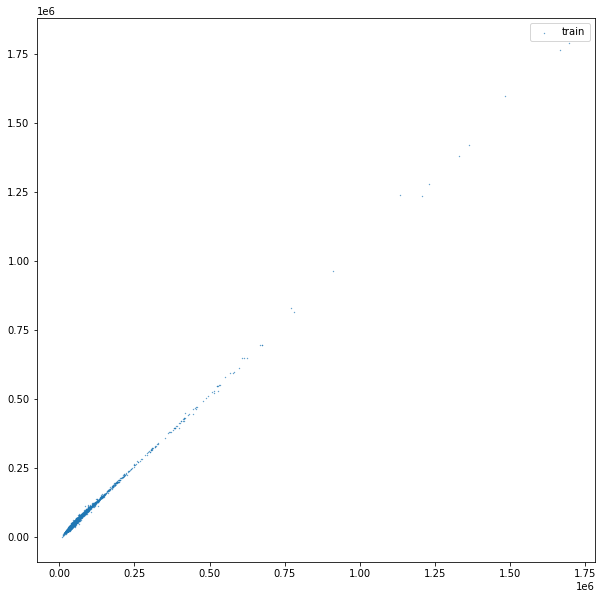

In [76]:
plt.figure(figsize=(10,10));
plt.scatter(train_predictions, y_train, label='train', s=0.1)
#plt.scatter(test_predictions, y_test, label='test', s=0.1
#         label='test',
#         s=1, c='green', linewidth=2, linestyle='dashed',
#         marker='o', markerfacecolor='blue', markersize=12
#        )
plt.legend();
#plt.show();

In [77]:
submission

array([48437.02137044, 43129.9144504 , 42898.77151211, ...,
       36264.71245117, 42272.61432512, 45224.0815129 ])

In [78]:
submission.shape

(2974,)

In [79]:
submit = pd.DataFrame()
submit['id'] = test['id'].copy()
submit['per_square_meter_price'] = submission
submit

,id,per_square_meter_price
279792,COL_289284,48437.021370
279793,COL_289305,43129.914450
279794,COL_289318,42898.771512
279795,COL_289354,92772.582189
279796,COL_289399,48795.229256
...,...,...
282761,COL_455089,25586.108523
282762,COL_455212,49420.218710
282763,COL_455261,36264.712451
282764,COL_455381,42272.614325


In [80]:
submit.to_csv('solution_08.csv', index=False)

**Умножаем на 0,94**

In [327]:
submission_094 = submission * 0.94
submission_094

array([34706.79047234, 45424.23926431, 45015.58911907, ...,
       38004.11188195, 56971.68507892, 45848.0362126 ])

In [328]:
submit = pd.DataFrame()
submit['id'] = test['id'].copy()
submit['per_square_meter_price'] = submission_094
submit

,id,per_square_meter_price
279792,COL_289284,34706.790472
279793,COL_289305,45424.239264
279794,COL_289318,45015.589119
279795,COL_289354,67286.528240
279796,COL_289399,66408.882066
...,...,...
282761,COL_455089,29809.183952
282762,COL_455212,38424.522490
282763,COL_455261,38004.111882
282764,COL_455381,56971.685079


In [329]:
submit.to_csv('solution_07.csv', index=False)